In [1]:
import sys
!{sys.executable} -m pip install tabulate

  Using cached tabulate-0.9.0-py3-none-any.whl.metadata (34 kB)
Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from pprint import pprint
from tabulate import tabulate
from datetime import datetime, timedelta


## Preliminary Analysis


To get familiar with the dataset and remove the outliers.

• What is the distribution of trip distance of different types of roads? Plot ecdf and make comments.



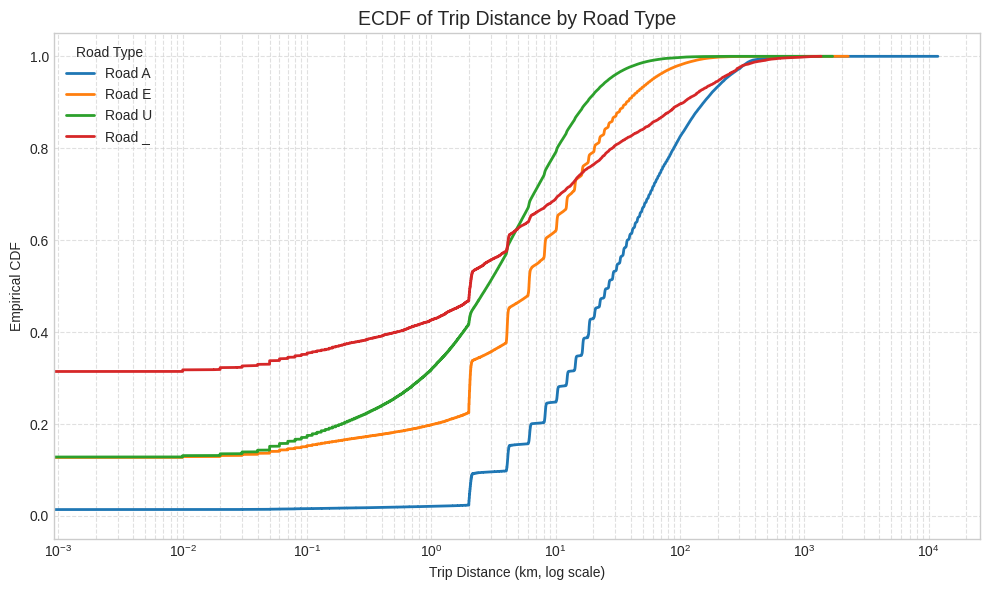

' Observations:\nUrban Roads (U): These trips typically have shorter distances, as seen by the steep rise in the ECDF at smaller distances.\nExpressways (E): The distances are more spread out, with a smoother, less steep ECDF curve, indicating longer trip distances on average.\n'

In [9]:
# Load the uploaded CSV file to explore its contents
file_path = r'Unipol_dataset_lab3.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
data.head(), data.columns

# Extract relevant columns for analysis
road_types = data['road']
distances = data['total_distance']

# Check for missing or invalid values in relevant columns
data_cleaned = data.dropna(subset=['road', 'total_distance'])

# Group by road type and calculate ECDF for each group
road_groups = data_cleaned.groupby('road')

# Function to compute ECDF
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x)+1) / len(x)
    return x, y

# Plot ECDF for each road type
plt.figure(figsize=(10, 6))

for road, group in road_groups:
    x, y = ecdf(group['total_distance'])
    plt.plot(
        x, y,
        linewidth=2,
        label=f'Road {road}'
    )

# Slight plot improvements (minimal changes)
plt.xscale('log')
plt.title('ECDF of Trip Distance by Road Type', fontsize=14)
plt.xlabel('Trip Distance (km, log scale)')
plt.ylabel('Empirical CDF')
plt.legend(title='Road Type')
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.tight_layout()

# Display the plot
plt.show()


''' Observations:
Urban Roads (U): These trips typically have shorter distances, as seen by the steep rise in the ECDF at smaller distances.
Expressways (E): The distances are more spread out, with a smoother, less steep ECDF curve, indicating longer trip distances on average.
'''

• What is the distribution of trip duration? Plot ecdf and make comments.



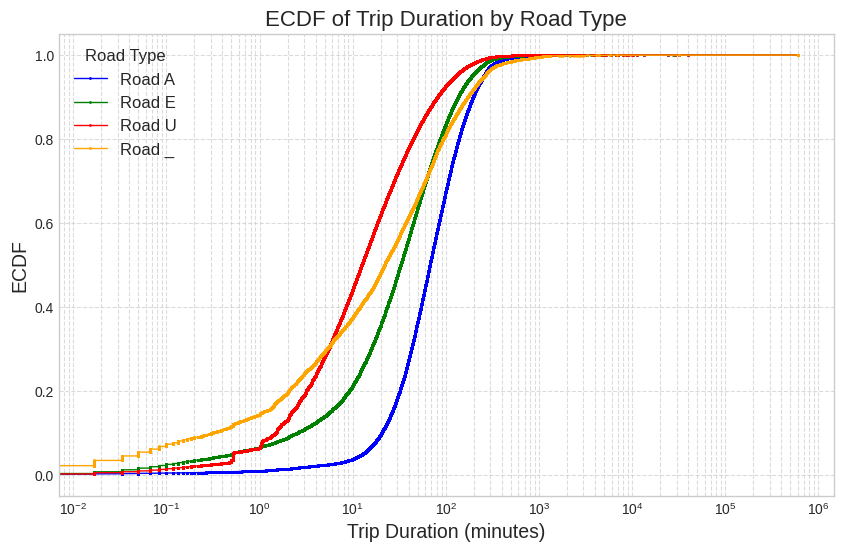

In [17]:
# Convert start_time and stop_time to datetime
data_cleaned['start_time'] = pd.to_datetime(data_cleaned['start_time'])
data_cleaned['stop_time'] = pd.to_datetime(data_cleaned['stop_time'])

# Calculate trip duration in minutes
data_cleaned['trip_duration'] = (data_cleaned['stop_time'] - data_cleaned['start_time']).dt.total_seconds() / 60

# Group by road type and calculate ECDF for trip duration
road_groups_duration = data_cleaned.groupby('road')


# Plot ECDF for trip duration for each road type
plt.figure(figsize=(10, 6))  # leggermente più grande
colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown']  # palette di colori distinti
for i, (road, group) in enumerate(road_groups_duration):
    x, y = ecdf(group['trip_duration'])
    plt.semilogx(x, y, marker='o', linestyle='-', linewidth=1, markersize=1, 
                 color=colors[i % len(colors)], label=f'Road {road}')

# Customize the plot
plt.title('ECDF of Trip Duration by Road Type', fontsize=16)
plt.xlabel('Trip Duration (minutes)', fontsize=14)
plt.ylabel('ECDF', fontsize=14)
plt.legend(title='Road Type', fontsize=12, title_fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.7)

# Display the plot
plt.show()



• What is the relationship between trip duration and distance? Can you spot any difference among
trips with different road types?


Correlation between trip duration and distance for each road type:
Road A: 0.03
Road E: 0.02
Road U: 0.02
Road _: 0.02


/opt/conda/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


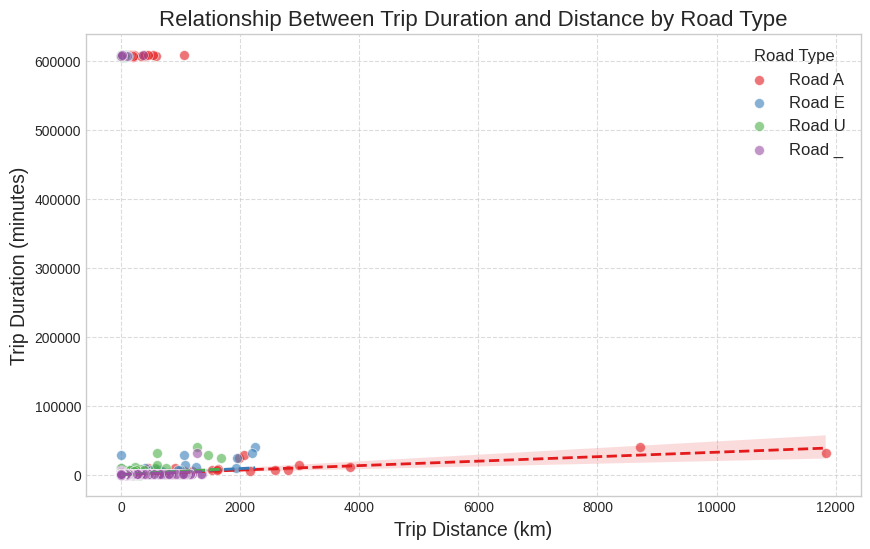

In [18]:
# Calculate correlation coefficients between trip duration and distance for each road type
road_correlation = {}
for road, group in road_groups:
    corr = group['trip_duration'].corr(group['total_distance'])
    road_correlation[road] = corr

# Display correlation coefficients
print("Correlation between trip duration and distance for each road type:")
for road, corr in road_correlation.items():
    print(f"Road {road}: {corr:.2f}")

# Scatter plot with regression lines for each road type
plt.figure(figsize=(10, 6))
palette = sns.color_palette('Set1', n_colors=len(road_groups))

for i, (road, group) in enumerate(road_groups):
    # Scatter points
    sns.scatterplot(
        x=group['total_distance'],
        y=group['trip_duration'],
        label=f'Road {road}',
        color=palette[i],
        s=50,  # marker size
        alpha=0.6
    )
    # Regression line
    sns.regplot(
        x=group['total_distance'],
        y=group['trip_duration'],
        scatter=False,
        color=palette[i],
        line_kws={"linestyle": "dashed", "linewidth": 2}
    )

# Customize the plot
plt.title('Relationship Between Trip Duration and Distance by Road Type', fontsize=16)
plt.xlabel('Trip Distance (km)', fontsize=14)
plt.ylabel('Trip Duration (minutes)', fontsize=14)
plt.legend(title='Road Type', fontsize=12, title_fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Display the plot
plt.show()



• Filter the dataset, remove outliers (e.g. distance 0, impossible distance wrt duration) and report your
filter criteria. How many valid trips are recorded in the dataset?

In [15]:
# Define filtering criteria
min_distance = 0.1      # Minimum valid distance in km
max_distance = 1500     # Maximum valid distance in km
min_duration = 0.5      # Minimum valid trip duration in minutes
max_duration = 2500     # Maximum valid trip duration in minutes
min_speed = 1           # Minimum average speed in km/h
max_speed = 200         # Maximum reasonable average speed in km/h

# Filter dataset: Remove rows outside distance and duration thresholds
filtered_data = data_cleaned[
    (data_cleaned['total_distance'] > min_distance) &
    (data_cleaned['total_distance'] <= max_distance) &
    (data_cleaned['trip_duration'] > min_duration) &
    (data_cleaned['trip_duration'] <= max_duration)
].copy()  # Use .copy() to avoid SettingWithCopyWarning

# Calculate average speed (km/h) and filter based on speed thresholds
filtered_data['average_speed'] = (
    filtered_data['total_distance'] / (filtered_data['trip_duration'] / 60)
)

filtered_data = filtered_data[
    (filtered_data['average_speed'] >= min_speed) &
    (filtered_data['average_speed'] <= max_speed)
]

# Count the number of valid trips
valid_trip_count = len(filtered_data)

# Display the filtering criteria and valid trip count
print("Filtering Criteria:")
print(f"1. Total distance > {min_distance} km and ≤ {max_distance} km")
print(f"2. Trip duration > {min_duration} minutes and ≤ {max_duration} minutes")
print(f"3. Average speed between {min_speed} km/h and {max_speed} km/h")
print(f"Number of valid trips: {valid_trip_count}")

# Output the first few rows of the filtered data for verification
print("\nSample of filtered data:")
print(filtered_data.head())

# Save filtered data to CSV
output_file = "filtered_trips.csv"
filtered_data.to_csv(output_file, index=False)
print(f"\nFiltered data saved to '{output_file}'.")


Filtering Criteria:
1. Total distance > 0.1 km and ≤ 1500 km
2. Trip duration > 0.5 minutes and ≤ 2500 minutes
3. Average speed between 1 km/h and 200 km/h
Number of valid trips: 1176567

Sample of filtered data:
   Unnamed: 0  vehicle_id  trip_id          start_time           stop_time  \
0           0           1        0 2023-09-29 13:55:35 2023-09-29 14:11:42   
1           1           1        0 2023-09-29 13:55:35 2023-09-29 14:11:42   
3           3           1        2 2023-09-29 15:12:03 2023-09-29 15:26:55   
4           4           1        2 2023-09-29 15:12:03 2023-09-29 15:26:55   
5           5           1        3 2023-09-29 15:37:38 2023-09-29 15:57:26   

  road  total_distance  trip_duration  average_speed  
0    E           14.31      16.116667      53.274043  
1    U            1.47      16.116667       5.472596  
3    E            2.60      14.866667      10.493274  
4    U            2.00      14.866667       8.071749  
5    E            2.24      19.800000      

/opt/conda/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


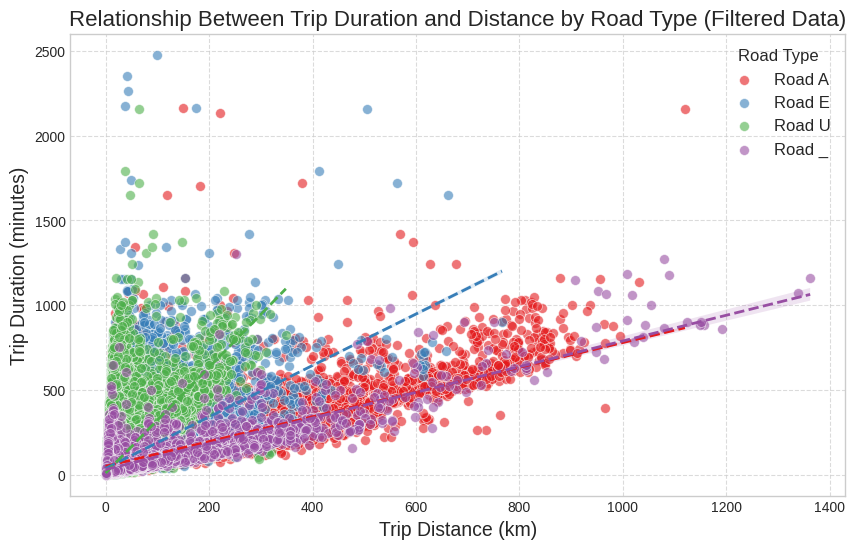

In [19]:
# Scatter plot with regression lines for each road type (filtered data)
plt.figure(figsize=(10, 6))
palette = sns.color_palette('Set1', n_colors=len(filtered_data['road'].unique()))

for i, (road, group) in enumerate(filtered_data.groupby('road')):
    # Scatter points
    sns.scatterplot(
        x=group['total_distance'],
        y=group['trip_duration'],
        label=f'Road {road}',
        color=palette[i],
        s=50,        # marker size
        alpha=0.6
    )
    # Regression line per road type
    sns.regplot(
        x=group['total_distance'],
        y=group['trip_duration'],
        scatter=False,
        color=palette[i],
        line_kws={"linestyle": "dashed", "linewidth": 2}
    )

# Customize the plot
plt.title('Relationship Between Trip Duration and Distance by Road Type (Filtered Data)', fontsize=16)
plt.xlabel('Trip Distance (km)', fontsize=14)
plt.ylabel('Trip Duration (minutes)', fontsize=14)
plt.legend(title='Road Type', fontsize=12, title_fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Display the plot
plt.show()


## Tasks
